In [1]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import json

In [2]:
with open('cred_sql.json') as f:
    creds = json.load(f)

In [3]:
con = mysql.connector.connect(user=creds['user_name'], password=creds['password'],
                              host=creds['host_name'],
                              database='employees')

In [4]:
# selecting the maximum and minimum hiring dates 
cursor = con.cursor()

sql ="""
SELECT MAX(hire_date), MIN(hire_date) 
FROM employees 
"""
cursor.execute(sql)
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

In [5]:
# Let's collect information about the last salary of each employee in the database
cursor = con.cursor()

sql = """
SELECT s.emp_no, s.salary, s.from_date, s.to_date
FROM salaries s
INNER JOIN (
    SELECT emp_no, MAX(to_date) AS to_date
    FROM salaries
    GROUP BY emp_no
) AS max_date ON s.emp_no = max_date.emp_no AND s.to_date = max_date.to_date;
"""

cursor.execute(sql)
cursor.fetchall()

[(10001, 88958, datetime.date(2002, 6, 22), datetime.date(9999, 1, 1)),
 (10002, 72527, datetime.date(2001, 8, 2), datetime.date(9999, 1, 1)),
 (10003, 43311, datetime.date(2001, 12, 1), datetime.date(9999, 1, 1)),
 (10004, 74057, datetime.date(2001, 11, 27), datetime.date(9999, 1, 1)),
 (10005, 94692, datetime.date(2001, 9, 9), datetime.date(9999, 1, 1)),
 (10006, 59755, datetime.date(2001, 8, 2), datetime.date(9999, 1, 1)),
 (10007, 88070, datetime.date(2002, 2, 7), datetime.date(9999, 1, 1)),
 (10008, 52668, datetime.date(2000, 3, 10), datetime.date(2000, 7, 31)),
 (10009, 94409, datetime.date(2002, 2, 14), datetime.date(9999, 1, 1)),
 (10010, 80324, datetime.date(2001, 11, 23), datetime.date(9999, 1, 1)),
 (10011, 56753, datetime.date(1996, 1, 21), datetime.date(1996, 11, 9)),
 (10012, 54423, datetime.date(2001, 12, 16), datetime.date(9999, 1, 1)),
 (10013, 68901, datetime.date(2001, 10, 16), datetime.date(9999, 1, 1)),
 (10014, 60598, datetime.date(2001, 12, 27), datetime.date(999

In [6]:
res = pd.read_sql(sql, con)

In [7]:
field_names = [i[0] for i in cursor.description]
display(field_names, res.shape, res.head(3))

['emp_no', 'salary', 'from_date', 'to_date']

(300180, 4)

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


In [8]:
# how many to_date values are equal to 9999-01-01 and how many are not
(res.to_date==datetime.date(9999, 1, 1)).value_counts()

True     240124
False     60056
Name: to_date, dtype: int64

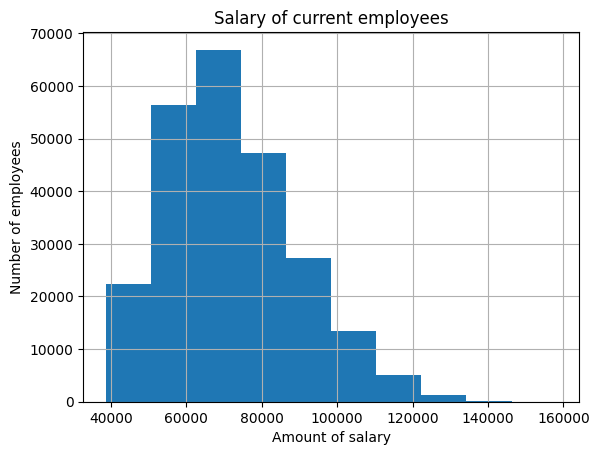

In [9]:
# let's display a histogram of salaries of employees who are still working in the company
res[res.to_date==datetime.date(9999, 1, 1)].salary.hist()
plt.title('Salary of current employees')
plt.xlabel('Amount of salary')
plt.ylabel('Number of employees');

This histogram clearly shows us that the average salary is 70000, the lowest is 40000 and the highest is about 120000-140000, but the number of employees getting such salary is extremely small.

In [10]:
# let's display a lineplot of correlation between the number of hired employees and the hiring year 
df = pd.read_sql(f"""
SELECT DISTINCT YEAR(hire_date) AS hire_year, COUNT(emp_no) AS emp_num
FROM employees 
GROUP BY hire_year
""", con)
df

,hire_year,emp_num
0,1986,36150
1,1985,35316
2,1989,28394
3,1994,14835
4,1990,25610
5,1992,20402
6,1987,33501
7,1995,12115
8,1993,17772
9,1999,1514


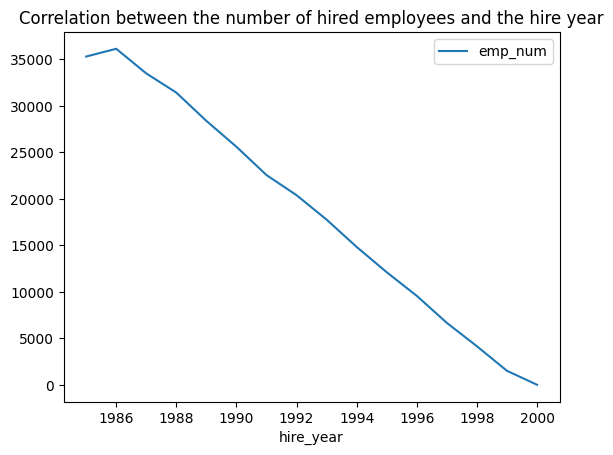

In [11]:
df.sort_values('hire_year').plot(x='hire_year', y='emp_num')
plt.title('Correlation between the number of hired employees and the hire year');

According to this lineplot the hiring peak in this company was in 1986 and by 2000 they almost stopped hiring new employees. So there's definitely correlation between the hiring year and the number of employees hired this year.

In [12]:
# Let's find the number of full years in the position for Engineers who are no longer working in the company
df_years = pd.read_sql(f"""
SELECT TIMESTAMPDIFF(YEAR, from_date, to_date) AS duration,
from_date, to_date
FROM titles
WHERE title = 'Engineer' AND to_date != '9999-01-01'
""", con)
df_years

,duration,from_date,to_date
0,9,1986-12-01,1995-12-01
1,5,1990-02-18,1995-02-18
2,8,1992-12-18,2000-12-18
3,8,1987-04-03,1995-04-03
4,5,1995-03-20,2001-03-19
...,...,...,...
84015,9,1989-11-23,1998-11-23
84016,5,1989-07-30,1994-07-30
84017,0,1993-02-22,1993-10-27
84018,6,1996-05-13,2002-05-13


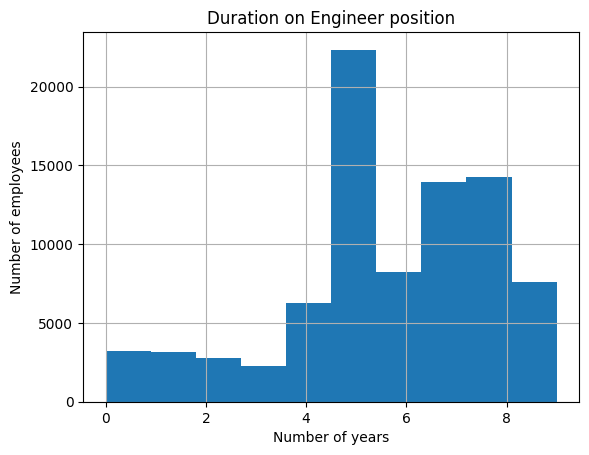

In [13]:
# let's plot a histogram of the duration on Engineer position
df_years.hist()
plt.title('Duration on Engineer position')
plt.xlabel('Number of years')
plt.ylabel('Number of employees');

According to the histogram Engineers usually stay in the company for a period of 5 years.

In [14]:
con.close()